file:///C:/Users/adame/Downloads/s10898-020-00882-3.pdf

In [1]:
import numpy as np
import pandas as pd
from itertools import product

from pyomo.environ import *

T = 7
alpha = 0.1
beta = 0.02

sources = ["s1", "s2"]
demands = ["d1", "d2"]
blenders = ["b1", "b2", "b3", "b4", "b5", "b6", "b7", "b8"]
properties = ["p1"]
timestamps = list(range(T))


s_amounts = {'s1': [10, 10, 10, 0, 0, 0, 0], 's2': [30, 30, 30, 0, 0, 0, 0]}
d_amounts = {'d1': [0, 0, 0, 15, 15, 15, 15], 'd2': [0, 0, 0, 15, 15, 15, 15]}

sigma = {"s1":{"p1": 0.06}, "s2":{"p1": 0.26}}

sigma_ub = {"d1":{"p1": 0.16}, "d2":{"p1": 1}}
sigma_lb = {"d1":{"p1": 0}, "d2":{"p1": 0}}

s_inv_lb = {'s1': 0, 's2': 0}
s_inv_ub = {'s1': 0, 's2': 0}

d_quals_lb = {'d1': 0, 'd2': 0}
d_quals_ub = {'d1': 0.16, 'd2': 0.1}
d_inv_lb = {'d1': 0, 'd2': 0}
d_inv_ub = {'d1': 0, 'd2': 0}
betaT_d = {'d1': 2, 'd2': 1}

b_inv_ub = {"b1": 30, "b2": 30, "b3": 30, "b4": 30, "b5": 20, "b6": 20, "b7": 20, "b8": 20}

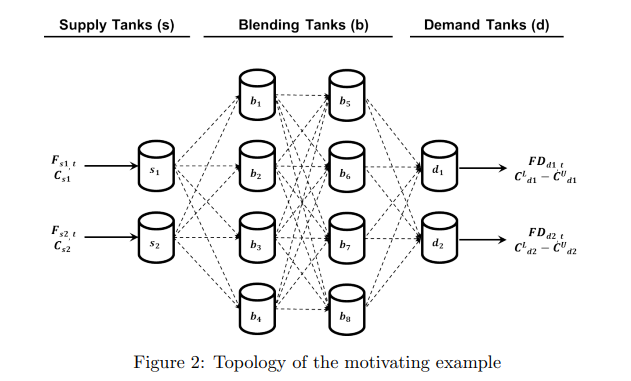

In [2]:
# Define connections manually
connections = {
    'source_blend':{
        's1': ['b1', 'b2', 'b3', 'b4'],
        's2': ['b1', 'b2', 'b3', 'b4']
    },
    
    'source_demand':{
        's1': [],
        's2': []
    },
    
    'blend_blend':{
        'b1': ['b5', 'b6', 'b7', 'b8'],
        'b2': ['b5', 'b6', 'b7', 'b8'],
        'b3': ['b5', 'b6', 'b7', 'b8'],
        'b4': ['b5', 'b6', 'b7', 'b8']
    },
    
    'blend_demand':{
        'b5': ['d1', 'd2'],
        'b6': ['d1', 'd2'],
        'b7': ['d1', 'd2'],
        'b8': ['d1', 'd2']
    }
}

In [3]:
# Model
model = ConcreteModel()

# Sets
model.sources = Set(initialize=sources)
model.demands = Set(initialize=demands)
model.blenders = Set(initialize=blenders)
model.properties = Set(initialize=properties)
model.timestamps = Set(initialize=timestamps)

In [4]:
# Parameters
model.s_inv_lb = Param(model.sources, initialize=s_inv_lb)
model.s_inv_ub = Param(model.sources, initialize=s_inv_ub)
model.s_amounts = Param(model.sources, initialize=s_amounts)
model.d_quals_lb = Param(model.demands, initialize=d_quals_lb)
model.d_quals_ub = Param(model.demands, initialize=d_quals_ub)
model.d_inv_lb = Param(model.demands, initialize=d_inv_lb)
model.d_inv_ub = Param(model.demands, initialize=d_inv_ub)
model.d_amounts = Param(model.demands, initialize=d_amounts)
model.betaT_d = Param(model.demands, initialize=betaT_d)
model.b_inv_ub = Param(model.blenders, initialize=b_inv_ub)

# Decision variables
model.source_inv = Var(model.sources, model.timestamps, domain=NonNegativeReals)
model.blend_inv = Var(model.blenders, model.timestamps, domain=NonNegativeReals)
model.demand_inv = Var(model.demands, model.timestamps, domain=NonNegativeReals)

model.prop_blend_inv = Var(model.properties, model.blenders, model.timestamps, domain=NonNegativeReals)

model.source_blend_flow = Var(model.sources, model.blenders, model.timestamps, domain=NonNegativeReals)
model.blend_blend_flow = Var(model.blenders, model.blenders, model.timestamps, domain=NonNegativeReals)
model.blend_demand_flow = Var(model.blenders, model.demands, model.timestamps, domain=NonNegativeReals)

model.source_blend_bin = Var(model.sources, model.blenders, model.timestamps, domain=Binary)
model.blend_blend_bin = Var(model.blenders, model.blenders, model.timestamps, domain=Binary)
model.blend_demand_bin = Var(model.blenders, model.demands, model.timestamps, domain=Binary)

'Any'. The default domain for Param objects is 'Any'.  However, we will be
changing that default to 'Reals' in the future.  If you really intend the
domain of this Paramto be 'Any', you can suppress this warning by explicitly
specifying 'within=Any' to the Param constructor.  (deprecated in 5.6.9, will
be removed in (or after) 6.0) (called from
c:\Users\adame\OneDrive\Bureau\CODE\blending_project\blendv\lib\site-
packages\pyomo\core\base\indexed_component.py:714)
'Any'. The default domain for Param objects is 'Any'.  However, we will be
changing that default to 'Reals' in the future.  If you really intend the
domain of this Paramto be 'Any', you can suppress this warning by explicitly
specifying 'within=Any' to the Param constructor.  (deprecated in 5.6.9, will
be removed in (or after) 6.0) (called from
c:\Users\adame\OneDrive\Bureau\CODE\blending_project\blendv\lib\site-
packages\pyomo\core\base\indexed_component.py:714)


In [5]:
model.s_amounts["s1"][0]

10

In [6]:
# Implement that flow = 0 if the pair is not in the dict connections
# def connections_rule0(model):
#     ...
    
# model.material_balance_rule0 = Constraint(rule=connections_rule0)

In [7]:
model.timestamps.prev(5)

4

In [8]:
def material_balance_rule1(model, s, t):
    if t == 0:
        return model.source_inv[s, t] == 0 # Initialize empty inventory at t=0
    else:
        return model.source_inv[s, t] == model.source_inv[s, model.timestamps.prev(t)] \
                                        + model.s_amounts[s][model.timestamps.prev(t)] \
                                        - sum(model.source_blend_flow[s, j, model.timestamps.prev(t)] for j in model.blenders)

model.material_balance_rule1 = Constraint(model.sources, model.timestamps, rule=material_balance_rule1)

In [9]:
def material_balance_rule1(model, s, t):
    if t == 0:
        return model.source_inv[s, t] == 0 # Initialize empty inventory at t=0
    else:
        return model.source_inv[s, t] == model.source_inv[s, model.timestamps.prev(t)] \
                                        + model.s_amounts[s][model.timestamps.prev(t)] \
                                        - sum(model.source_blend_flow[s, j, model.timestamps.prev(t)] for j in model.blenders)

model.material_balance_rule1 = Constraint(model.sources, model.timestamps, rule=material_balance_rule1)

(type=<class 'pyomo.core.base.constraint.IndexedConstraint'>) on block unknown
with a new Component (type=<class
'pyomo.core.base.constraint.IndexedConstraint'>). This is usually indicative
of a modelling error. To avoid this warning, use block.del_component() and
block.add_component().


In [10]:
def material_balance_rule2(model, j, t):
    if t == 0:
        return model.blend_inv[j, t] == 0 # Initialize empty inventory at t=0
    else:
        return model.blend_inv[j, t] == model.blend_inv[j, model.timestamps.prev(t)] \
                                    + sum(model.source_blend_flow[s, j, model.timestamps.prev(t)] for s  in model.sources) \
                                    + sum(model.blend_blend_flow[jp, j, model.timestamps.prev(t)] for jp in model.blenders) \
                                    - sum(model.blend_blend_flow[j, jp, model.timestamps.prev(t)] for jp in model.blenders) \
                                    - sum(model.blend_demand_flow[j, d, model.timestamps.prev(t)] for d  in model.demands)

model.material_balance_rule2 = Constraint(model.blenders, model.timestamps, rule=material_balance_rule2)

In [11]:
def material_balance_rule3(model, p, t):
    if t == 0:
        return model.demand_inv[p, t] == 0 # Initialize empty inventory at t=0
    else:
        return model.demand_inv[p, t] == model.demand_inv[p, model.timestamps.prev(t)] \
                                    + sum(model.blend_demand_flow[j, p, model.timestamps.prev(t)] for j in model.blenders) \
                                    - model.d_amounts[p][model.timestamps.prev(t)]

model.material_balance_rule3 = Constraint(model.demands, model.timestamps, rule=material_balance_rule3)

In [12]:
M = 999999
def material_balance_rule4(model, s, j, t):
    return model.source_blend_flow[s, j, t] <= M * model.source_blend_bin[s, j, t]

model.material_balance_rule4 = Constraint(model.sources, model.blenders, model.timestamps, rule=material_balance_rule4)

In [13]:
def material_balance_rule5(model, s, j, p, t):
    return model.source_blend_bin[s, j, t] <= 1 - model.blend_demand_bin[j, p, t]

model.material_balance_rule5 = Constraint(model.sources, model.blenders, model.demands, model.timestamps, rule=material_balance_rule5)

In [14]:
def material_balance_rule6(model, q, j, t):
    if t == 0:
        return model.prop_blend_inv[q, j, t] == 0 # Initialize empty inventory at t=0
    else:
        return model.prop_blend_inv[q, j, t] * model.blend_inv[j, t] == model.prop_blend_inv[q, j, model.timestamps.prev(t)] * model.blend_inv[j, model.timestamps.prev(t)] \
                                                    + sum(sigma[s][q] * model.source_blend_flow[s, j, model.timestamps.prev(t)] for s in model.sources) \
                                                    + sum(model.prop_blend_inv[q, jp, model.timestamps.prev(t)] * model.blend_blend_flow[jp, j, model.timestamps.prev(t)] for jp in model.blenders) \
                                                    - sum(model.prop_blend_inv[q, j,  model.timestamps.prev(t)] * model.blend_blend_flow[j, jp, model.timestamps.prev(t)] for jp in model.blenders) \
                                                    - sum(model.prop_blend_inv[q, j,  model.timestamps.prev(t)] * model.blend_demand_flow[j, p, model.timestamps.prev(t)] for p in model.demands) \

model.material_balance_rule6 = Constraint(model.properties, model.blenders, model.timestamps, rule=material_balance_rule6)

In [15]:
def material_balance_rule7_1(model, q, p, j, t):
    return sigma_lb[p][q] - M * (1 - model.blend_demand_bin[j, p, t]) <= model.prop_blend_inv[q, j, t]

def material_balance_rule7_2(model, q, p, j, t):
    return sigma_ub[p][q] + M * (1 - model.blend_demand_bin[j, p, t]) >= model.prop_blend_inv[q, j, t]

model.material_balance_rule7_1 = Constraint(model.properties, model.demands, model.blenders, model.timestamps, rule=material_balance_rule7_1)
model.material_balance_rule7_2 = Constraint(model.properties, model.demands, model.blenders, model.timestamps, rule=material_balance_rule7_2)

In [18]:
def obj_function(model):
    return  sum(
                sum(  
                      sum(alpha * model.source_blend_bin[s, j, t] + beta * model.source_blend_flow[s, j, t] for s in model.sources) \
                    + sum(alpha * model.blend_blend_bin[j, jp, t] + beta * model.blend_blend_flow[j, jp, t] for jp in model.blenders) \
                    + sum(alpha * model.blend_demand_bin[j, p, t] + beta * model.blend_demand_flow[j, p, t] for p in model.demands) 
                for t in model.timestamps) 
            for j in model.blenders)

model.obj = Objective(rule=obj_function, sense=minimize)

'pyomo.core.base.objective.ScalarObjective'>) on block unknown with a new
Component (type=<class 'pyomo.core.base.objective.ScalarObjective'>). This is
usually indicative of a modelling error. To avoid this warning, use
block.del_component() and block.add_component().


In [19]:
# Solve the model
solver = SolverFactory('gurobi')
solver.solve(model, tee=True)

Set parameter Username
Academic license - for non-commercial use only - expires 2025-03-19
Read LP format model from file C:\Users\adame\AppData\Local\Temp\tmp6vsd8bsy.pyomo.lp
Reading time = 0.01 seconds
x1: 652 rows, 1484 columns, 2340 nonzeros
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22631.2))

CPU model: 11th Gen Intel(R) Core(TM) i5-11300H @ 3.10GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 652 rows, 1484 columns and 2340 nonzeros
Model fingerprint: 0xfcaf15c8
Model has 48 quadratic constraints
Variable types: 812 continuous, 672 integer (672 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+04]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [6e-02, 3e-01]
  Objective range  [2e-02, 1e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+04]
Presolve removed 496 rows and 756 columns
Presolve time: 0.00s
Presolved: 1860 row

{'Problem': [{'Name': 'x1', 'Lower bound': 3.7, 'Upper bound': 3.7, 'Number of objectives': 1, 'Number of constraints': 700, 'Number of variables': 1484, 'Number of binary variables': 672, 'Number of integer variables': 672, 'Number of continuous variables': 812, 'Number of nonzeros': 2340, 'Sense': 'minimize'}], 'Solver': [{'Status': 'ok', 'Return code': '0', 'Message': 'Model was solved to optimality (subject to tolerances), and an optimal solution is available.', 'Termination condition': 'optimal', 'Termination message': 'Model was solved to optimality (subject to tolerances), and an optimal solution is available.', 'Wall time': '0.7370002269744873', 'Error rc': 0, 'Time': 1.1211481094360352}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

In [30]:
M = [[[model.source_blend_flow[s, b, t].value for b in model.blenders] for s in model.sources] for t in model.timestamps]
N = [[[model.blend_blend_flow[b1, b2, t].value for b2 in model.blenders] for b1 in model.blenders] for t in model.timestamps]
O = [[[model.blend_demand_flow[b, p, t].value for p in model.demands] for b in model.blenders] for t in model.timestamps]

Mp = [[[model.source_blend_bin[s, b, t].value for b in model.blenders] for s in model.sources] for t in model.timestamps]
Np = [[[model.blend_blend_bin[b1, b2, t].value for b2 in model.blenders] for b1 in model.blenders] for t in model.timestamps]
Op = [[[model.blend_demand_bin[b, p, t].value for p in model.demands] for b in model.blenders] for t in model.timestamps]

Mi = [[model.source_inv[s, t].value for s in model.sources] for t in model.timestamps]
Ni = [[model.blend_inv[b, t].value for b in model.blenders] for t in model.timestamps]
Oi = [[model.demand_inv[p, t].value for p in model.demands] for t in model.timestamps]

for t in range(T):
    print(f"\nt{t}:")
    print("s2b")
    for s in range(len(model.sources)):
        print(M[t][s])
    print("b2b")
    for b in range(len(model.blenders)):
        print(N[t][b])
    print("b2p")
    for b in range(len(model.blenders)):
        print(O[t][b])
        
for t in range(T):
    print(f"\nt{t}:")
    print("s2b")
    for s in range(len(model.sources)):
        print(Mp[t][s])
    print("b2b")
    for b in range(len(model.blenders)):
        print(Np[t][b])
    print("b2p")
    for b in range(len(model.blenders)):
        print(Op[t][b])

for t in range(T):
    print(f"\nt{t}:")
    print(Mi[t])
    print(Ni[t])
    print(Oi[t])
    
print("Objective Value:", model.obj())


t0:
s2b
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
b2b
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
b2p
[0.0, 0.0]
[0.0, 0.0]
[0.0, 0.0]
[0.0, 0.0]
[0.0, 0.0]
[0.0, 0.0]
[0.0, 0.0]
[0.0, 0.0]

t1:
s2b
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
b2b
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
b2p
[0.0, 0.0]
[0.0, 0.0]
[0.0, 0.0]
[0.0, 0.0]
[0.0, 0.0]
[0.